In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# cwd = os.getcwd()
# cwd

In [3]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('TG.csv')
df=raw_csv_data.copy()

In [4]:
para = 'Recovered'

In [5]:
df.Date.describe()

count           115
unique          115
top       11-Jun-20
freq              1
Name: Date, dtype: object

In [6]:
df

,Date,Confirmed,Recovered,Decreased
0,14-Mar-20,1,0,0
1,15-Mar-20,2,1,0
2,16-Mar-20,1,0,0
3,17-Mar-20,1,0,0
4,18-Mar-20,8,0,0
...,...,...,...,...
110,02-Jul-20,1213,987,8
111,03-Jul-20,1892,1126,8
112,04-Jul-20,1850,1342,5
113,05-Jul-20,1590,1166,7


In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,1,0,0
1,2020-03-15,2,1,0
2,2020-03-16,1,0,0
3,2020-03-17,1,0,0
4,2020-03-18,8,0,0


In [9]:
df

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,1,0,0
1,2020-03-15,2,1,0
2,2020-03-16,1,0,0
3,2020-03-17,1,0,0
4,2020-03-18,8,0,0
...,...,...,...,...
110,2020-07-02,1213,987,8
111,2020-07-03,1892,1126,8
112,2020-07-04,1850,1342,5
113,2020-07-05,1590,1166,7


In [10]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [11]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,1,0,0
2020-03-15,2,1,0
2020-03-16,1,0,0
2020-03-17,1,0,0
2020-03-18,8,0,0
...,...,...,...
2020-07-02,1213,987,8
2020-07-03,1892,1126,8
2020-07-04,1850,1342,5


In [12]:
# df.Date.describe()

In [13]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,1,0,0
2020-03-15,2,1,0
2020-03-16,1,0,0
2020-03-17,1,0,0
2020-03-18,8,0,0
...,...,...,...
2020-07-02,1213,987,8
2020-07-03,1892,1126,8
2020-07-04,1850,1342,5


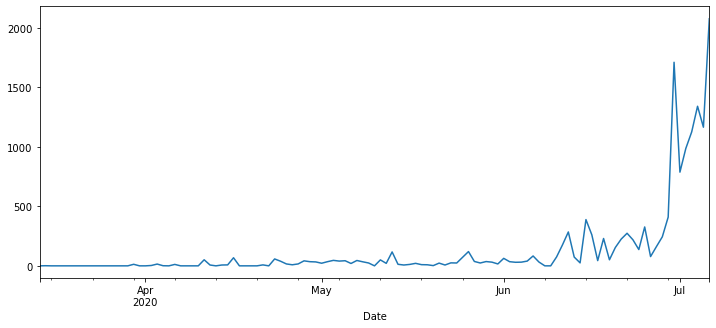

In [14]:
df[para].plot(figsize=(12,5));

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic        3.644453
p-value                   1.000000
# lags used              13.000000
# observations          101.000000
critical value (1%)      -3.496818
critical value (5%)      -2.890611
critical value (10%)     -2.582277
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


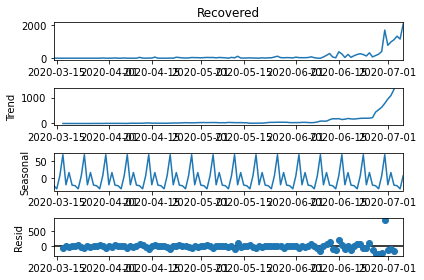

In [17]:
result = seasonal_decompose(df[para])
result.plot();

In [18]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [19]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.157942
p-value                  0.691421
# lags used             13.000000
# observations          99.000000
critical value (1%)     -3.498198
critical value (5%)     -2.891208
critical value (10%)    -2.582596
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [20]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=3)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1615.844, BIC=1621.299, Time=0.010 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1557.828, BIC=1566.010, Time=0.020 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1513.880, BIC=1522.062, Time=0.119 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1613.924, BIC=1616.651, Time=0.010 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1529.896, BIC=1540.805, Time=0.027 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=1512.460, BIC=1526.097, Time=0.085 seconds
Fit ARIMA(4,2,0)x(0,0,0,0) [intercept=True]; AIC=1512.614, BIC=1528.979, Time=0.103 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1487.965, BIC=1504.330, Time=0.201 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1488.087, BIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -735.182
Date:                Tue, 14 Jul 2020   AIC                           1478.364
Time:                        05:03:16   BIC                           1489.274
Sample:                             0   HQIC                          1482.791
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7480      4.017      0.435      0.663      -6.124       9.620
ma.L1         -1.6323      0.102    -15.977      0.000      -1.832      -1.432
ma.L2          0.7374      0.075      9.860      0.000       0.591       0.884
sigma2      2.542e+04   1597.007     15.915      0.000    2.23e+04    2.85e+04
===================================================================================
Ljung-Box (Q):                       18.67   Jarque-Bera (JB):             14930.49
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             141.03   Skew:                             6.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = df.iloc[:90]
test = df.iloc[90:]

In [22]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# model = ARIMA(train[para],order=(2,2,1))
model = SARIMAX(train[para],order=(2,2,1),seasonal_order=(2,2,1,3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         Recovered   No. Observations:                   90
Model:             SARIMAX(2, 2, 1)x(2, 2, 1, 3)   Log Likelihood                -419.685
Date:                           Tue, 14 Jul 2020   AIC                            853.371
Time:                                   05:03:16   BIC                            870.218
Sample:                               03-14-2020   HQIC                           860.134
                                    - 06-11-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4436      0.170     -2.612      0.009      -0.776      -0.111
ar.L2         -0.2501      0.221     -1.131      0.258      -0.684       0.184
ma.L1         -0.9968      3.040     -0.328      0.743      -6.954       4.961
ar.S.L3       -0.9047      0.169     -5.347      0.000      -1.236      -0.573
ar.S.L6       -0.3960      0.155     -2.551      0.011      -0.700      -0.092
ma.S.L3       -0.9980      9.019     -0.111      0.912     -18.675      16.679
sigma2      1169.3198   8871.789      0.132      0.895   -1.62e+04    1.86e+04
===================================================================================
Ljung-Box (Q):                       43.70   Jarque-Bera (JB):                33.18
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               4.18   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(2,2,1,3) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

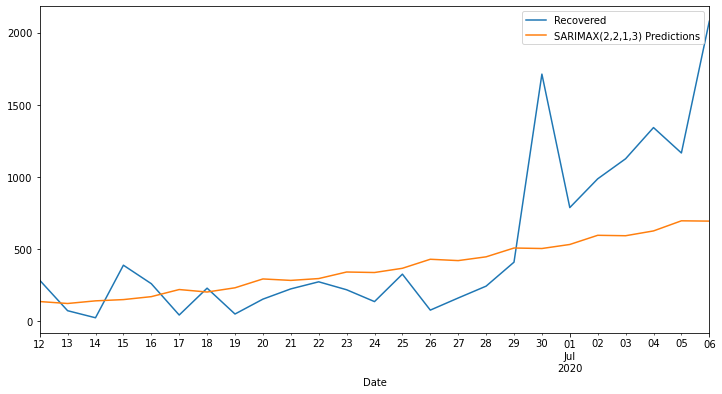

In [25]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [26]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [27]:
from sklearn.metrics import mean_absolute_error
MAPE = mean_absolute_error(predictions, test[para])
MAPE

299.25163814057584

In [28]:
per_MAPE = (MAPE/sum(test[para]))*100
print(per_MAPE,'%')

2.3400972641583975 %


In [29]:
type(predictions)

pandas.core.series.Series

In [30]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Decreased,d1,forecast
Date,,,,,
2020-03-14,1,0,0,NaN,NaN
2020-03-15,2,1,0,NaN,NaN
2020-03-16,1,0,0,-2.0,NaN
2020-03-17,1,0,0,1.0,NaN
2020-03-18,8,0,0,0.0,NaN
...,...,...,...,...,...
2020-07-02,1213,987,8,1123.0,596.044411
2020-07-03,1892,1126,8,-60.0,593.038811
2020-07-04,1850,1342,5,77.0,626.344057


In [31]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Recovered': Date
 2020-06-12     285
 2020-06-13      74
 2020-06-14      25
 2020-06-15     389
 2020-06-16     261
 2020-06-17      44
 2020-06-18     230
 2020-06-19      51
 2020-06-20     154
 2020-06-21     225
 2020-06-22     274
 2020-06-23     219
 2020-06-24     137
 2020-06-25     327
 2020-06-26      78
 2020-06-27     162
 2020-06-28     244
 2020-06-29     410
 2020-06-30    1712
 2020-07-01     788
 2020-07-02     987
 2020-07-03    1126
 2020-07-04    1342
 2020-07-05    1166
 2020-07-06    2078
 Freq: D, Name: Recovered, dtype: int64,
 'Predicted_Recovered': 2020-06-12    137.356227
 2020-06-13    123.890774
 2020-06-14    142.170374
 2020-06-15    150.870060
 2020-06-16    171.269018
 2020-06-17    220.534776
 2020-06-18    203.312805
 2020-06-19    232.567861
 2020-06-20    293.846940
 2020-06-21    283.804089
 2020-06-22    296.475284
 2020-06-23    341.903520
 2020-06-24    338.389126
 2020-06-25    367.646854
 2020-06-26    430.140525
 2020-06-27    420.864304
 

In [32]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Recovered,Predicted_Recovered
Date,,
2020-06-12,285,137.356227
2020-06-13,74,123.890774
2020-06-14,25,142.170374
2020-06-15,389,150.870060
2020-06-16,261,171.269018
2020-06-17,44,220.534776
2020-06-18,230,203.312805
2020-06-19,51,232.567861
2020-06-20,154,293.846940


In [33]:
# predicted_csv = predicted_df.to_csv('Predicted_TG.csv')
predicted_csv = pd.read_csv('Predicted_TG.csv')

predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
predicted_csv.set_index('Date', inplace=True)
predicted_csv.index.freq = 'D'
# print(predicted_csv)
# predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(predicted_csv)
predicted_csv.to_csv('Predicted_TG.csv')

            Confirmed  Predicted_Confirmed  Recovered  Predicted_Recovered
Date                                                                      
2020-06-12        164           252.328205        285           137.356227
2020-06-13        253           243.721551         74           123.890774
2020-06-14        237           228.995013         25           142.170374
2020-06-15        219           304.357924        389           150.870060
2020-06-16        213           288.469855        261           171.269018
2020-06-17        269           269.413666         44           220.534776
2020-06-18        352           343.978271        230           203.312805
2020-06-19        499           343.986249         51           232.567861
2020-06-20        546           343.065580        154           293.846940
2020-06-21        730           413.157017        225           283.804089
2020-06-22        872           405.486573        274           296.475284
2020-06-23        879    

In [34]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [35]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [36]:
future_datest_df.tail()

,Confirmed,Recovered,Decreased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [37]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Decreased,forecast
2020-03-14,1,0,0,NaN
2020-03-15,2,1,0,NaN
2020-03-16,1,0,0,NaN
2020-03-17,1,0,0,NaN
2020-03-18,8,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [38]:
future_df[[para, 'forecast']]

,Recovered,forecast
2020-03-14,0,NaN
2020-03-15,1,NaN
2020-03-16,0,NaN
2020-03-17,0,NaN
2020-03-18,0,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [39]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [40]:
future_df['forecast'] = future_pred

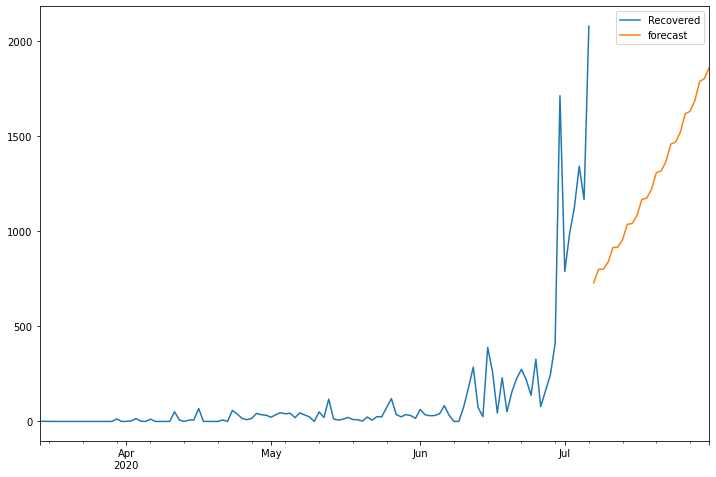

In [41]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [42]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Recovered': 2020-07-07     728.001367
 2020-07-08     799.520432
 2020-07-09     800.312366
 2020-07-10     837.737152
 2020-07-11     913.902799
 2020-07-12     915.844167
 2020-07-13     956.182022
 2020-07-14    1036.352539
 2020-07-15    1040.450590
 2020-07-16    1083.337882
 2020-07-17    1167.080847
 2020-07-18    1173.318291
 2020-07-19    1219.621018
 2020-07-20    1307.804330
 2020-07-21    1316.020537
 2020-07-22    1365.321764
 2020-07-23    1457.554005
 2020-07-24    1468.123720
 2020-07-25    1520.680321
 2020-07-26    1617.194526
 2020-07-27    1630.064882
 2020-07-28    1686.032122
 2020-07-29    1786.995019
 2020-07-30    1802.288029
 2020-07-31    1861.646291
 Freq: D, dtype: float64}

In [43]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Recovered
2020-07-07,728.001367
2020-07-08,799.520432
2020-07-09,800.312366
2020-07-10,837.737152
2020-07-11,913.902799
2020-07-12,915.844167
2020-07-13,956.182022
2020-07-14,1036.352539
2020-07-15,1040.450590
2020-07-16,1083.337882


In [44]:
# future_predicted_csv = future_predicted_df.to_csv('Future_Predicted_TG.csv')
# future_predicted_df.index.freq = 'D'
# future_predicted_csv = future_predicted_df.to_csv('Future_Predicted_TG.csv')

future_predicted_csv = pd.read_csv('Future_Predicted_TG.csv')

future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
future_predicted_csv.set_index('Date', inplace=True)
future_predicted_csv.index.freq = 'D'
# print(future_predicted_csv)
# future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(future_predicted_csv)
future_predicted_csv.to_csv('Future_Predicted_TG.csv')

            Future_Predicted_Confirmed  Future_Predicted_Recovered
Date                                                              
2020-07-07                  793.184355                  728.001367
2020-07-08                  791.242405                  799.520432
2020-07-09                  888.997171                  800.312366
2020-07-10                  890.028814                  837.737152
2020-07-11                  888.849483                  913.902799
2020-07-12                  990.963503                  915.844167
2020-07-13                  993.760968                  956.182022
2020-07-14                  994.525206                 1036.352539
2020-07-15                 1100.456032                 1040.450590
2020-07-16                 1104.741279                 1083.337882
2020-07-17                 1107.010277                 1167.080847
2020-07-18                 1217.251932                 1173.318291
2020-07-19                 1223.017296                 1219.62